In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

In [2]:
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import numpy as np
import time

nb.__version__

'0.55.2'

# The invariant distribution and the numerical simulation at "infinite" times
In this section, I am interested in comparing a numerical approximation to the infinite double well SDE at infinite time to its invariant distribution. 

The Hamiltonian of a bounded system can be written as:
$$
    dX_j = - \nabla V(X_j) dt + \sqrt{2 \tau} dB_j.
$$
where $V(x) = \frac{1}{2x^2}+x^2$. 

To do so, I design a code using numba that simulates one path of a numerical approximation of the SDE (using Euler Maruyama) and follow this path for a very long time. Using ergodicity, the distribution of the samples of this path should converge to the invariant distribution. 

This piece of code will go through the different parameter that can vary and look at how they impact how the distribution of the simulated path is close to the invariant distribution. 

## Exploration

Below, I explore the potential function of the related SDE in order to have an idea of what behaviour to expect from the generated samples of the positions. 

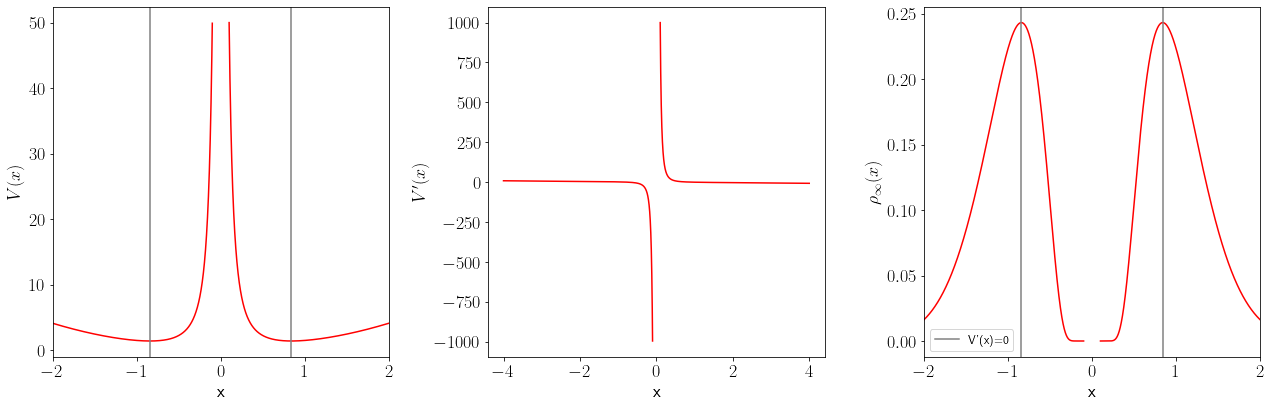

In [43]:
## Infinite double well system
    
def U(x):
    """
    potential of the infinite double well
    """

    return (1/(2*x**2)+x*x)

def pinf(x,tau):
    return np.exp(-U(x)/tau)

def dU(x):
    """
    potential of the double well
    """

    return -(-x**(-3)+2*x)

##--------set the axis 
b=4
x1=np.arange(0.1,b,0.0001)
x2=np.arange(-b,-0.1,0.0001)

## ------- Plot 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,6))# plt.figure(figsize=(4,4))

ax1.plot(x1,U(x1),color="r")
ax1.plot(x2,U(x2),color="r")
ax1.set_xlabel("x")
ax1.set_ylabel("$V(x)$")
ax1.axvline(x=1/np.sqrt(np.sqrt(2)),color="grey",label="V'(x)=0")
ax1.axvline(x=-1/np.sqrt(np.sqrt(2)),color="grey")
ax1.set_xlim(-2,2)

ax2.plot(x2,dU(x2),color="r")
ax2.set_ylabel("$ V'(x)$")
ax2.plot(x1,dU(x1),color="r")
ax2.set_xlabel("x")

# plt.legend()
ax3.set_xlabel("x")
ax3.plot(x2,pinf(x2,1),color="r")
ax3.plot(x1,pinf(x1,1),color="r")
ax3.set_ylabel("$\\rho_{\infty}(x)$")
ax3.axvline(x=1/np.sqrt(np.sqrt(2)),color="grey",label="V'(x)=0")
ax3.axvline(x=-1/np.sqrt(np.sqrt(2)),color="grey")
ax3.set_xlim(-2,2)
ax3.legend()

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

## Sample path examples

In this section, I generate some examples of samples path with different time discretisation values $\Delta t$ and temperature $\tau$.




Text(0, 0.5, 'x')

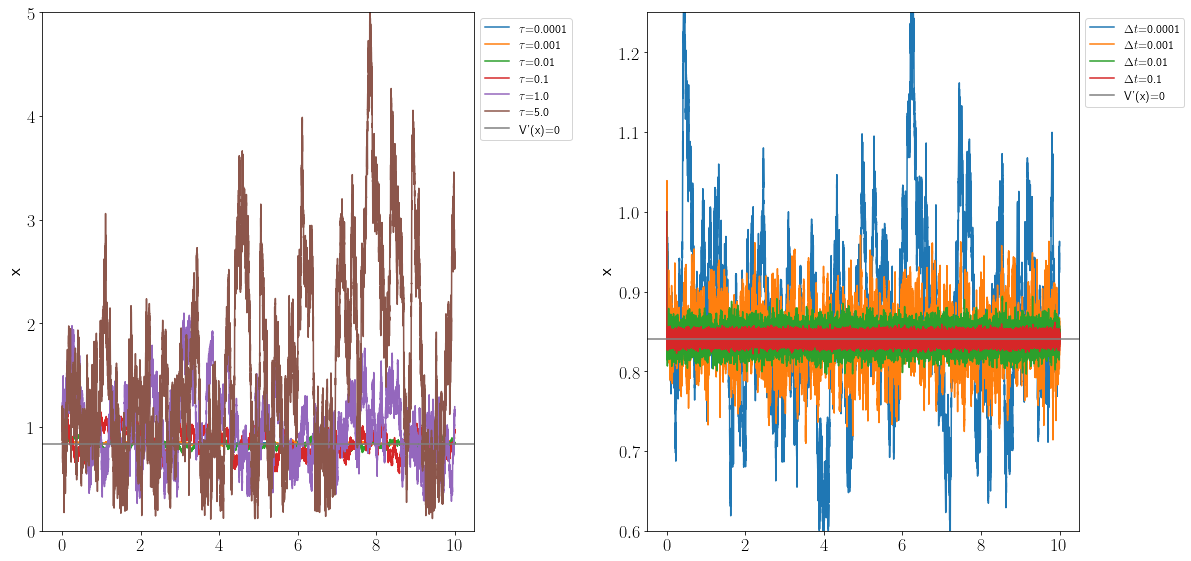

In [8]:
def run_num_plot(T,N,dt,s):
    """
    This function is similar to the one designed above but it is designed to work
    without numba and to produce samples examples of paths generated. 
    """
    y0 = 1 #initial condition
    y_full = [y0]
    for ii in range(N*T):
        b1 = np.random.normal(0,1)
        y1 = e_m_fast(y0,s,b1,dt)
        y_full.append(y1)
        y0=y1
        
    return np.array(y_full)

run_num_plot(1,10,0.1,0.1)

# ---------- Generate samples path for different values of tau -------------
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,9))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

N=10**4 #Time discretisation
T=10 #Final time
t_list=np.arange(0,T+1/(N),1/(N)) #list of time discretise to plot 
dt = float(1/N)  #size of the time steps
tau_list = np.array([0.0001,0.001,0.01,0.1,1,5]) #list of values of tau considered
for i in range(len(tau_list)): #loop through the different values of tau
    tau_i=tau_list[i] #get the value of tau
    s = np.sqrt(2*tau_i*dt) #get the related stochastic multiplicative term
    y_full=run_num_plot(T,N,dt,s) #value of X(T) as approximated by the numerical scheme
    ax1.set_ylim(0, 5) #zoom between -5 and 5 on the plot
    ax1.plot(t_list,y_full,label="$\\tau$="+str(round(tau_i,5))) #plot the paths

ax1.axhline(y=1/np.sqrt(np.sqrt(2)),color="grey",label="V'(x)=0")
ax1.axhline(y=-1/np.sqrt(np.sqrt(2)),color="grey") 

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# plt.title("Plot of example paths with different values of $\\tau $ ") #add the title
ax1.set_ylabel("x")

# ---------- Generate samples path for different values of \Delta t -------------

N=10**4 #Time discretisation
T=10 #Final time
t_list=np.arange(0,T+1/(N),1/(N)) #list of time discretise to plot 
dt = float(1/N)  #size of the time steps
dt_list = np.array([0.0001,0.001,0.01,0.1]) #,0.5]) #list of values of tau considered
tau = 0.1

for i in range(len(dt_list)): #loop through the different values of tau
    dti=dt_list[i] #get the value of tau
    s = np.sqrt(2*tau*dt) #get the related stochastic multiplicative term
    y_full=run_num_plot(T,N,dti,s) #value of X(T) as approximated by the numerical scheme
    ax2.set_ylim(0.6, 1.25) #zoom between -5 and 5 on the plot
    ax2.plot(t_list,y_full,label="$\Delta t$="+str(round(dti,5))) #plot the paths

ax2.axhline(y=1/np.sqrt(np.sqrt(2)),color="grey",label="V'(x)=0")
ax2.axhline(y=-1/np.sqrt(np.sqrt(2)),color="grey") 
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
ax2.set_ylabel("x")



In [ ]:
# ---------- Generate samples path for different values of tau -------------

N=10**4 #Time discretisation
T=10 #Final time
t_list=np.arange(0,T+1/(N),1/(N)) #list of time discretise to plot 
dt = float(1/N)  #size of the time steps
Npaths=500
all_paths = []
for i in range(Npaths): #loop through the different values of tau
    s = np.sqrt(2*10*dt) #get the related stochastic multiplicative term
    y_full=run_num_plot(T,N,dt,s) #value of X(T) as approximated by the numerical scheme
    all_paths.append(y_full) #save the result


Text(0, 0.5, 'x')

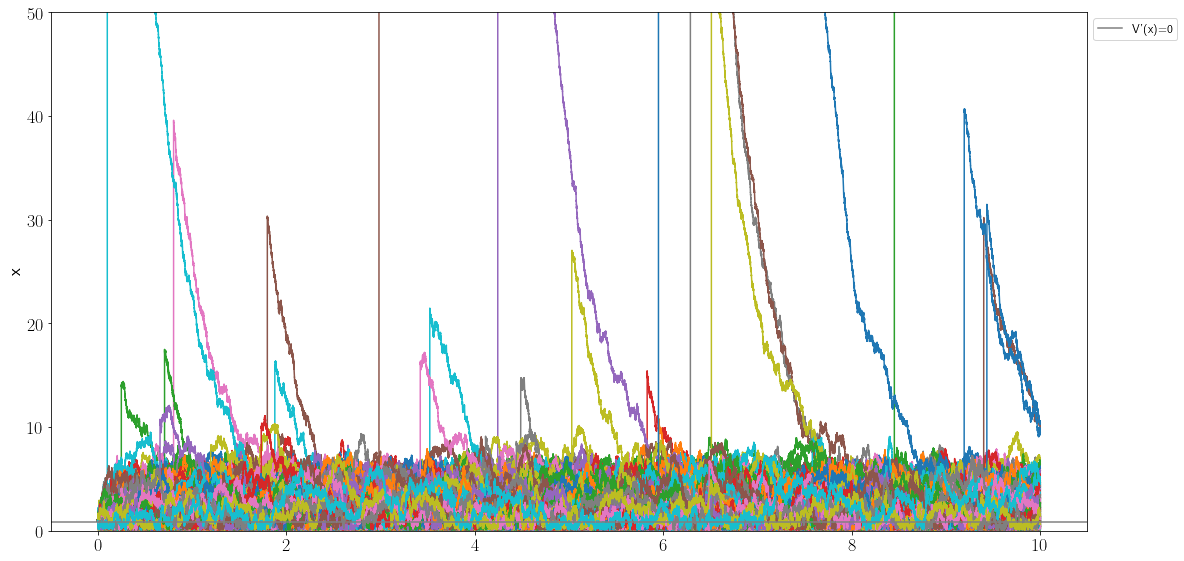

In [42]:
fig, (ax1) = plt.subplots(1, 1,figsize=(18,9))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
for i in range(Npaths): #loop through the different values of tau
    y_full=all_paths[i]
    ax1.plot(t_list,y_full) #plot the paths
    ax1.set_ylim(0,50)
ax1.axhline(y=1/np.sqrt(np.sqrt(2)),color="grey",label="V'(x)=0")
ax1.axhline(y=-1/np.sqrt(np.sqrt(2)),color="grey") 

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# plt.title("Plot of example paths with different values of $\\tau $ ") #add the title
ax1.set_ylabel("x")

As seen on this plot, it happens that one path spikes up to really far away position, due to the fact that it hits the potential barrier. One question is to know whether that kind of behaviour is consistent with a physical reality. It is hard to say whether those spikes are the results of numerical errors or they are the results of physical reality. One way to assess that would be to look at the value of the potential of these particles at each point. The noise can be seen as a force perturbating the particle. Indeed, the energy is perturbated.

In [37]:
## collect the paths that exceed a certain treshold to pick up those "crazy paths".
paths=[]

for i in range(Npaths): #loop through the different values of tau
    y_full=np.array(all_paths[i])
    for elem in y_full:
        if elem>25:
            paths.append(i)
            break

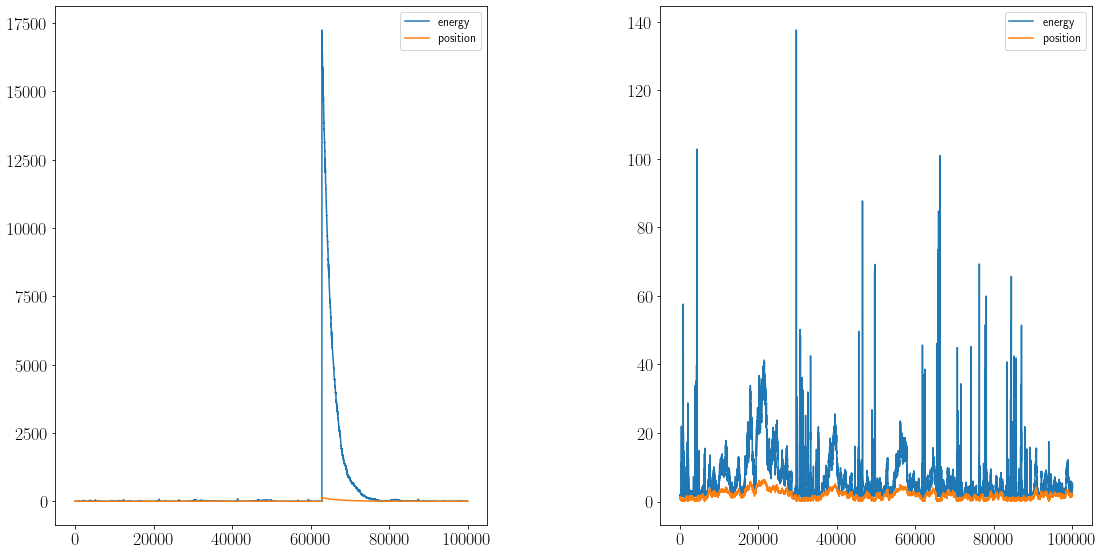

In [41]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,9))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

def U(q):
    res = 1/(2*q^2)+q^2
    return res

# for i in range(Npaths): #loop through the different values of tau
    # y_full=np.array(all_paths[i])
    # y_full2=np.multiply(y_full,y_full)
    # energy_y = 0.5*np.divide(1,y_full2) + y_full2

y_full=np.array(all_paths[37])
y_full2=np.multiply(y_full,y_full)
energy_y = 0.5*np.divide(1,y_full2) + y_full2
ax1.plot(energy_y,label="energy")
ax1.plot(y_full,label="position")
ax1.legend()

y_full=np.array(all_paths[30])
y_full2=np.multiply(y_full,y_full)
energy_y = 0.5*np.divide(1,y_full2) + y_full2
ax2.plot(energy_y,label="energy")
ax2.plot(y_full,label="position")
ax2.legend()


when one of the paths gets really high, the energy increases as well. It is hard to determine in that case what is due to the numerical error and the reality. 

## Numba code

The functions below are written using numba. 

In [7]:
# define the gradV function 
@njit(float64(float64))
def dU(x):
    """
    Compute the potential of the infinite double well:
    x: float 
    """

    return -1/(x*x*x)+2*x

@njit(float64(float64,float64,float64,float64))
def e_m_fast(y0,s,b1,dt):
    """
    The Euler-Maruyama scheme applied to the infinite double well
    y0: float
        value of y at t_n
    tau: float
        value of the temperature 
    b1: float
        brownian increment 
    dt: float
        time increment
    """
    y1=y0 - dU(y0)*dt+s*b1
    return y1    
    

    
# @njit(float64(float64,float64,float64,float64))
# def run_num(y0,s,dt,N):
#     """
#     Run the simulation for one sample path
#     Input
#     -----
#     N: int
#         Number of steps taken in T=1 sec
#     dt: float 
#         Value of time increment. Is 1/N.
#     s: float 
#         Is sqrt(2 \tau). 
#     T: int
#         Final time
#     Return
#     ------
#     yf: float
#         Value of X(T) as approximated by the numerical scheme chosen
        
#     """
#     for ii in range(N):
#         b1 = np.random.normal(0,1,1)[0]
#         y1 = e_m_fast(y0,s,b1,dt)
#         y0=y1 
#     return y1



@njit() #float64[:](float64,float64,float64,float64))
def DW_sde_fast(N,dt,tau): # Function is compiled and runs in machine code
    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    N: int
        Number of time steps 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    y_final = [] #np.zeros(n_samples)
    s = np.sqrt(2*tau*dt)
    n_esc=0
    y0 = 2 #initial condition
    for jj in range(N): # Run until T= Tsec
        b1 = np.random.normal(0,1,1)[0]
        y1 = e_m_fast(y0,s,b1,dt)
        y0=y1 
        y_final.append(y1)
    y_final=np.array(y_final)
    return y_final

%time y_compile = DW_sde_fast(10**2,10**(-6),0.001) # compile the function


CPU times: user 13 s, sys: 208 ms, total: 13.3 s
Wall time: 13.2 s


The potential is defined below in order to be able to plot the invariant distribution, which has the form: $\rho_{\infty} = C \exp \left(-\frac{V(x)}{\tau}\right)$


In [5]:
def U(x):
    """
    potential of -the infinite double well
    """

    return (1/(2*x**2)+x*x)


## Show how numerical simulations differs from the invariant distribution

I want to show how the numerical simulation compares to the invariant distribution. In particular, I am interested by how the time increment $\Delta t$, the temperature $\tau$ and the final time $T_f$ impacts this difference. 

### Different values of the time increment  
Below I am looking at varying the time discretisation parameter $\Delta t$. We expect that as the time discretisation parameter decreases, the numerical error should decreases as well and the distribution of the simulated sample path should be closer to the invariant distribution. For this simulation, we use the value of the temperature at $\tau = 0.01$, and set the number of simulation to $N$. 

In [33]:
## Plot results on the simulation
N=10**7
tau=0.01
dt_list=[0.5,0.2,0.1,10**(-2),10**(-3),10**(-4)]

# empty vector to save results
y_res = []
for i in range(len(dt_list)):
    dti=dt_list[i]
    y_exact = DW_sde_fast(N,dti,tau)
    y_res.append(y_exact)
    

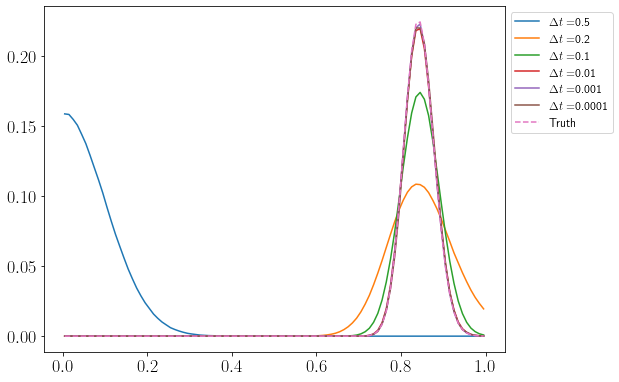

In [34]:
# axis of the plot 
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


## Plot 1 
for i in range(len(dt_list)):
    ye = y_res[i]
    dti = dt_list[i]
    histogram,bins = np.histogram(ye,bins=100,range=[0,1], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    ax.plot(midx,histogram,label='$\Delta t=$'+str(dti))
    
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (U(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
rho=(rho/np.sum(rho))*2
ax.plot(midx,rho,'--',label='Truth')      
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# ax.set_ylim(0,0.125)



It is interesting to see that as the time discretisation $\Delta t$ decreases, the distribution get closer to the invariant distribution. Something interesting happens with an increment $\Delta t =0.5$. It seems that this value triggers a different convergence to the invariant distribution. This value is definitely too high to allow Euler-Maruyama to converge. Similarly, the time interval $\Delta t = 0.1$ and $\Delta t=0.1$ does not allow convergence toward the invariant distribution. 

In [62]:
## Plot results on the simulation
N=10**7
tau=0.01
dt_list=[0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,10**(-2)]

# empty vector to save results
y_res = []
for i in range(len(dt_list)):
    dti=dt_list[i]
    y_exact = DW_sde_fast(N,dti,tau)
    y_res.append(y_exact)

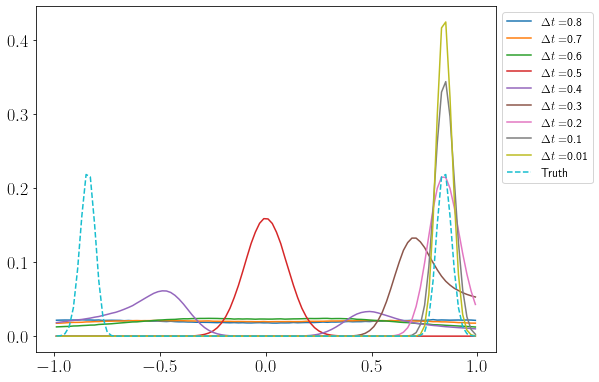

In [63]:
# axis of the plot 
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


## Plot 1 
for i in range(len(dt_list)):
    ye = y_res[i]
    dti = dt_list[i]
    histogram,bins = np.histogram(ye,bins=100,range=[-1,1], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    ax.plot(midx,histogram,label='$\Delta t=$'+str(dti))
    
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (U(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
rho=(rho/np.sum(rho))*2
ax.plot(midx,rho,'--',label='Truth')      
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# ax.set_ylim(0,0.125)



### Different values of the temperature  
Below I am looking at varying the temperature parameter $\tau$. We expect that as the temperature increases, the error should increase. The distribution of the simulated sample path should be further to the invariant distribution. For this simulation, we use the value of the time discretisation $\Delta t = 0.01$.

In [91]:
## Plot results on the simulation
N = 10**8
dt=0.01
tau_list = [0.1,0.5]+[i for i in range(1,9)]

# empty vector to save results
y_res_tau = np.zeros((len(tau_list),N))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact = DW_sde_fast(N,dt,tau_i)
    y_res_tau[i,::]=y_exact
    

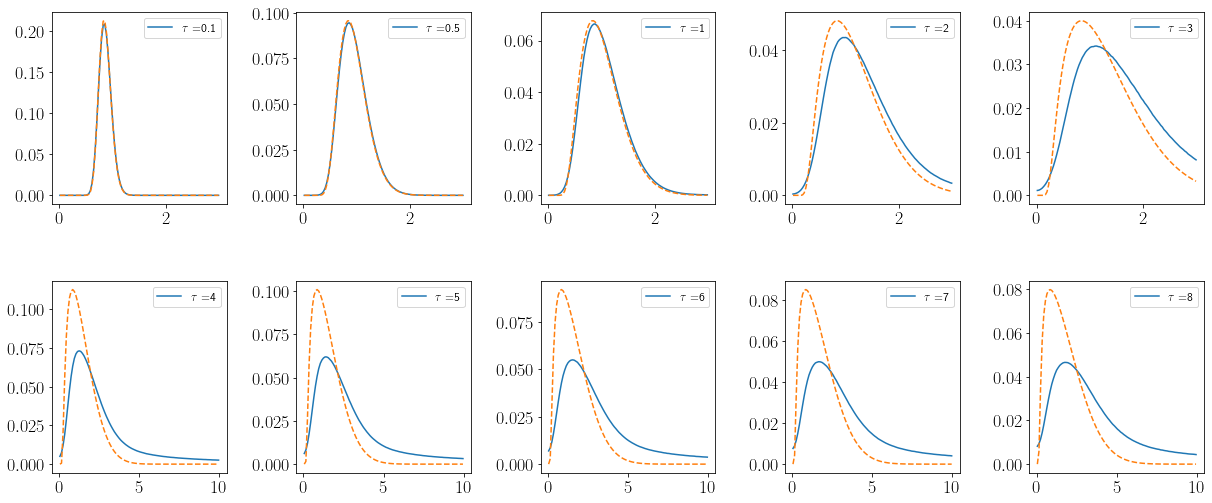

In [93]:
# axis of the plot 
fig, (axs)= plt.subplots(2, 5,figsize=(20,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



## Plot 1 
for i in range(len(tau_list)):

    ye = y_res_tau[i,::] #exctract the result of interest from the list
    tau_i = tau_list[i] #exctract the value of tau of interest from the list 


    # value of the indexes for the plot and bounds for histograms
    bounds=[0,3]
    j=0
    if i>4:
        j=1
        i= i-5
        bounds=[0,10]

    histogram,bins = np.histogram(ye,bins=100,range=bounds, density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    axs[j,i].plot(midx,histogram,label='$\\tau =$'+str(tau_i))
    axs[j,i].legend() #add the legend

    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- (U(midx)/tau_i))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    axs[j,i].plot(midx,rho,'--',label='Truth')   
    

In the plot above, one can see that when the temperature increases, the distribution on the long term does not converge to the invariant distribution anymore. The two distributions are not similar. When the time discretisation is set to $\Delta t=0.01$, the change seems to happen between the value of the temperature $\tau=0.1$ and $\tau=2$. 

In [106]:
## Plot results on the simulation
N = 10**7
dt=0.01
tau_list = np.round(np.arange(0.5,2,0.1),3)
# empty vector to save results
y_res_tau = np.zeros((len(tau_list),N))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact = DW_sde_fast(N,dt,tau_i)
    y_res_tau[i,::]=y_exact

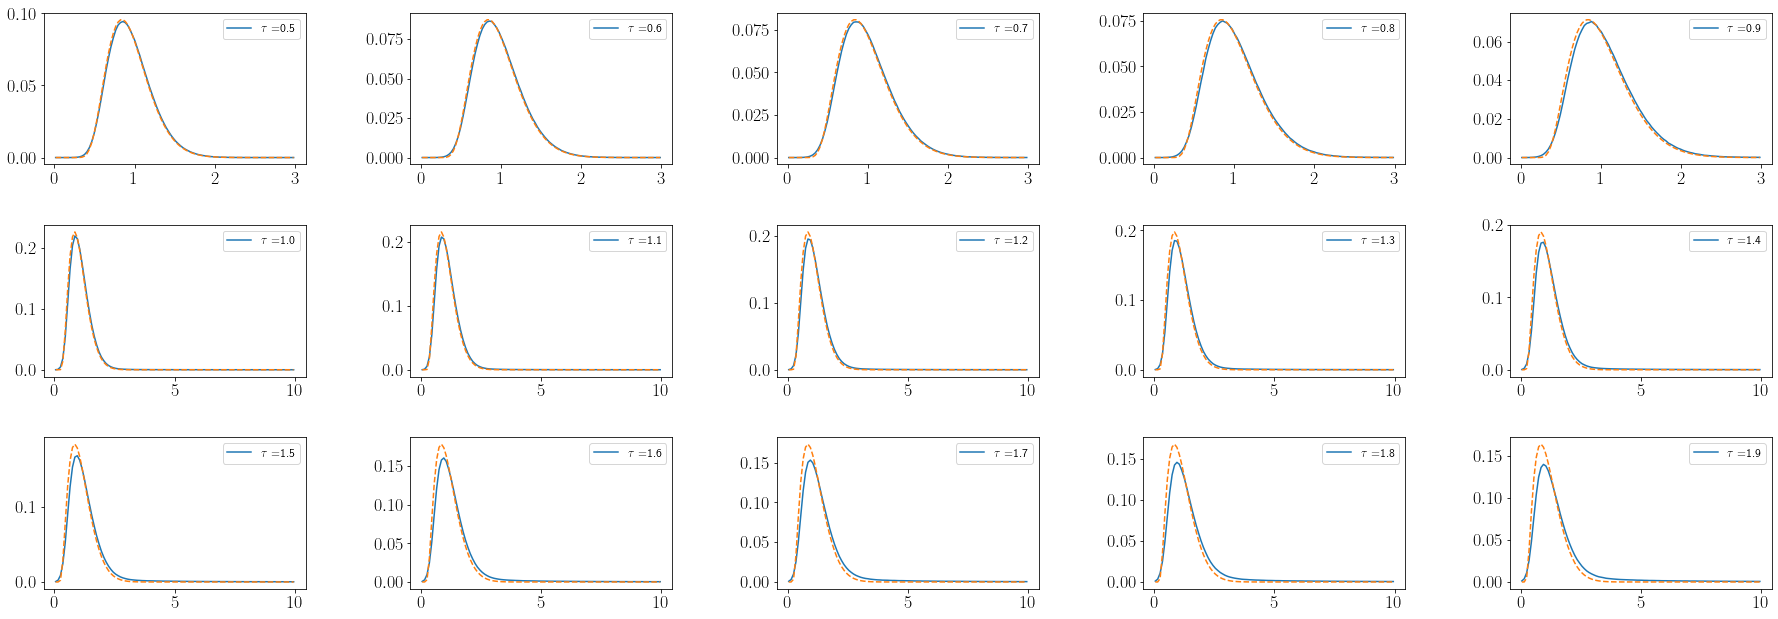

In [107]:
# axis of the plot 
fig, (axs)= plt.subplots(3, 5,figsize=(30,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



## Plot 1 
for i in range(len(tau_list)):

    ye = y_res_tau[i,::] #exctract the result of interest from the list
    tau_i = tau_list[i] #exctract the value of tau of interest from the list 


    # value of the indexes for the plot and bounds for histograms
    bounds=[0,3]
    j=0
    if i>9:
        j=2
        i= i-10
        bounds=[0,10]
    elif i>4:
        j=1
        i= i-5
        bounds=[0,10]

    #Histograms
    histogram,bins = np.histogram(ye,bins=100,range=bounds, density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    axs[j,i].plot(midx,histogram,label='$\\tau =$'+str(tau_i))
    axs[j,i].legend() #add the legend

    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- (U(midx)/tau_i))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    axs[j,i].plot(midx,rho,'--',label='Truth')  

When looking more in details into in which range of values of $\tau$ are interesting, we seen that the divergence from the true distribution is appearant between 0.5 and 2 for a time discretisation parameter of $\Delta t=0.01$.

Now, if we increase the value of the time discretisation $\Delta t=0.05$, let's see how the distributions are affected. 

In [17]:
## Plot results on the simulation
N = 10**8
dt=0.05
tau_list = [0.02,0.05,0.1,0.5]+[i for i in range(1,7)]

# empty vector to save results
y_res_tau = np.zeros((len(tau_list),N))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact = DW_sde_fast(N,dt,tau_i)
    y_res_tau[i,::]=y_exact
    

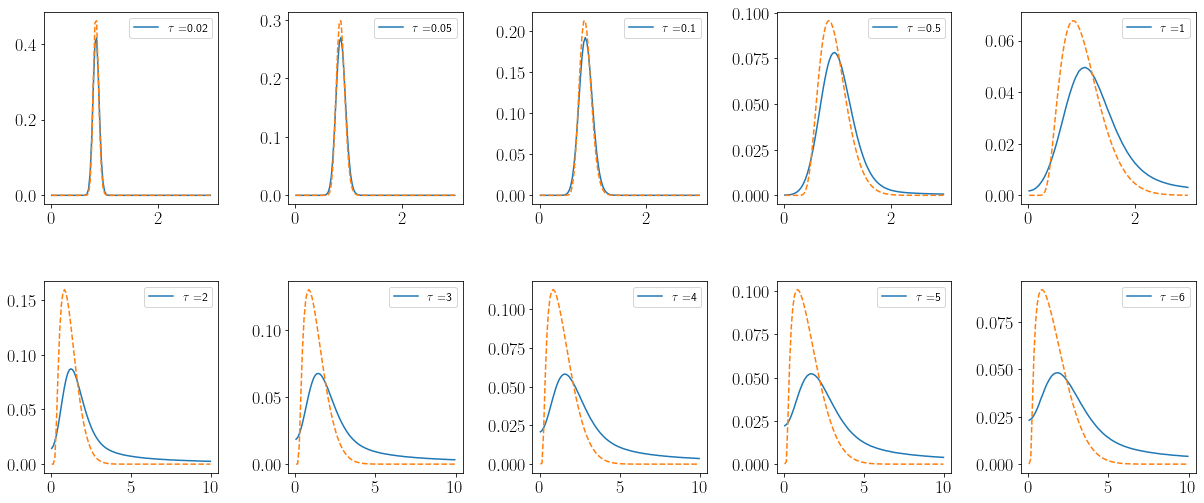

In [18]:
# axis of the plot 
fig, (axs)= plt.subplots(2, 5,figsize=(20,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



## Plot 1 
for i in range(len(tau_list)):

    ye = y_res_tau[i,::] #exctract the result of interest from the list
    tau_i = tau_list[i] #exctract the value of tau of interest from the list 


    # value of the indexes for the plot and bounds for histograms
    bounds=[0,3]
    j=0
    if i>4:
        j=1
        i= i-5
        bounds=[0,10]

    histogram,bins = np.histogram(ye,bins=100,range=bounds, density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    axs[j,i].plot(midx,histogram,label='$\\tau =$'+str(tau_i))
    axs[j,i].legend() #add the legend

    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- (U(midx)/tau_i))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    axs[j,i].plot(midx,rho,'--',label='Truth')   
    